In [2]:
import numpy as np
from matplotlib import pyplot as plt 

In [3]:
size = 1408 * 1
shape = (size,1)
BYTES_PER_PACKET = 1408
shape_global = (size,1)
shape_local = (BYTES_PER_PACKET,1)
recv_data_global = np.empty(shape_global, dtype = np.uint8)
data_partial = np.empty(shape_local, dtype = np.uint8)
num_it = (size // BYTES_PER_PACKET)
udp_message_global = np.random.randint(low=0, high=((2**8)-1), size=shape, dtype=np.uint8)

In [4]:
f = "/home/jonathan/Documents/Chalmers/Year5/DAT480/Lab_Project/test_vec.txt"
np.savetxt(f,udp_message_global,newline="",fmt="%d ")


In [25]:
# Send 64 bytes of text
    txt = "Hi my name is Jonathan, what is your name? How long is the txt?"


63

## Ruleset histogram


In [13]:
r = open("/home/jonathan/Documents/Chalmers/Year5/DAT480/Lab_Project/pattern_match_snort3_content.txt")
rules = r.read()
r.close()
rules = rules.splitlines(True)

occurances = np.zeros(len(rules), dtype=int)
max_length = 0
lengths = []
for line in rules:
    line_length = int(len(line))
    lengths.append(line_length)
    if(line_length > max_length):
        max_length = line_length
    occurances[line_length] += 1

In [22]:
np.unique(lengths,return_counts=True)[1].shape

(106,)

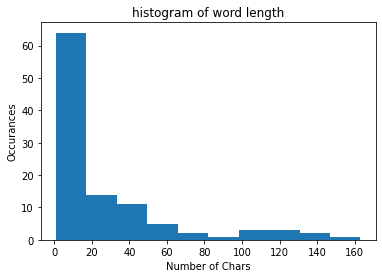

In [20]:
#bins=np.linspace(0, max_length)
plt.hist(occurances[occurances != 0])
plt.title("histogram of word length") 
plt.xlabel("Number of Chars")
plt.ylabel("Occurances")
plt.show()
#plt.rcParams['figure.dpi'] = 100